In [1]:
%pip install -q textblob vaderSentiment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pickle


# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report,
                              confusion_matrix)

# Download NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print(" All libraries imported!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


 All libraries imported!


In [2]:
# Load from CSV (created in Phase 1)
df = pd.read_csv('cleaned_reviews.csv')

# Keep only Positive and Negative for binary classification
# (easier for beginners, better model accuracy)
df_model = df[df['sentiment'] != 'Neutral'].copy()
df_model = df_model.reset_index(drop=True)

print(f"Data loaded: {len(df_model):,} reviews")
print(f"Positive: {len(df_model[df_model['sentiment']=='Positive']):,}")
print(f"Negative: {len(df_model[df_model['sentiment']=='Negative']):,}")

Data loaded: 19,817 reviews
Positive: 17,447
Negative: 2,370


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Keep some useful words that NLTK removes by default
keep_words = {'not', 'no', 'never', 'very', 'too', 'but'}
stop_words = stop_words - keep_words

def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove special characters
    import re
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(w) for w in words
             if w not in stop_words and len(w) > 2]
    
    return ' '.join(words)

print("Preprocessing text... (may take 1-2 minutes)")
df_model['processed_text'] = df_model['cleaned_review'].apply(preprocess_text)
print("Text preprocessing complete!")

# Preview
print("\nSample Review Before vs After:")
print(f"BEFORE: {df_model['review_text'].iloc[0][:100]}")
print(f"AFTER:  {df_model['processed_text'].iloc[0][:100]}")

Preprocessing text... (may take 1-2 minutes)
Text preprocessing complete!

Sample Review Before vs After:
BEFORE: Absolutely wonderful - silky and sexy and comfortable
AFTER:  absolutely wonderful silky sexy comfortable


In [5]:
print("\n" + "="*60)
print("APPROACH A: TextBlob Sentiment Analysis")
print("="*60)

def textblob_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_model['textblob_sentiment'] = df_model['review_text'].apply(textblob_sentiment)

# Evaluate TextBlob
textblob_acc = accuracy_score(
    df_model['sentiment'],
    df_model['textblob_sentiment']
)
print(f" TextBlob Accuracy: {textblob_acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(df_model['sentiment'],
                             df_model['textblob_sentiment']))


APPROACH A: TextBlob Sentiment Analysis
 TextBlob Accuracy: 88.26%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.23      0.32      2370
     Neutral       0.00      0.00      0.00         0
    Positive       0.90      0.97      0.94     17447

    accuracy                           0.88     19817
   macro avg       0.48      0.40      0.42     19817
weighted avg       0.86      0.88      0.86     19817



c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [6]:
print("\n" + "="*60)
print("APPROACH B: VADER Sentiment Analysis")
print("="*60)

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_model['vader_sentiment'] = df_model['review_text'].apply(vader_sentiment)

vader_acc = accuracy_score(
    df_model['sentiment'],
    df_model['vader_sentiment']
)
print(f"VADER Accuracy: {vader_acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(df_model['sentiment'],
                             df_model['vader_sentiment']))


APPROACH B: VADER Sentiment Analysis
VADER Accuracy: 88.94%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.26      0.37      2370
     Neutral       0.00      0.00      0.00         0
    Positive       0.91      0.97      0.94     17447

    accuracy                           0.89     19817
   macro avg       0.52      0.41      0.44     19817
weighted avg       0.88      0.89      0.87     19817



c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [7]:
print("\n" + "="*60)
print("APPROACH C: Machine Learning Models")
print("="*60)

# Prepare data
X = df_model['processed_text']
y = df_model['sentiment']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

# Convert text to numbers using TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,   # Use top 10,000 words
    ngram_range=(1, 2),   # Use single words + word pairs
    min_df=2              # Ignore very rare words
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(f"\n TF-IDF Matrix Shape: {X_train_tfidf.shape}")
print(f"   (rows=reviews, cols=unique words/phrases)")

# ── Model 1: Logistic Regression ──
print("\n Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_acc  = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_acc*100:.2f}%")

# ── Model 2: Naive Bayes ──
print("\n Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_acc  = accuracy_score(y_test, nb_pred)
print(f" Naive Bayes Accuracy: {nb_acc*100:.2f}%")

# Detailed report for best model
print("\n Best Model - Detailed Classification Report:")
print(classification_report(y_test, lr_pred))


APPROACH C: Machine Learning Models
Training samples: 15,853
Testing samples:  3,964

 TF-IDF Matrix Shape: (15853, 10000)
   (rows=reviews, cols=unique words/phrases)

 Training Logistic Regression...
Logistic Regression Accuracy: 92.53%

 Training Naive Bayes...
 Naive Bayes Accuracy: 89.86%

 Best Model - Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.45      0.59       474
    Positive       0.93      0.99      0.96      3490

    accuracy                           0.93      3964
   macro avg       0.89      0.72      0.78      3964
weighted avg       0.92      0.93      0.91      3964




MODEL COMPARISON
              Model  Accuracy       Type
Logistic Regression     92.53   ML Model
        Naive Bayes     89.86   ML Model
              VADER     88.94 Rule-Based
           TextBlob     88.26 Rule-Based


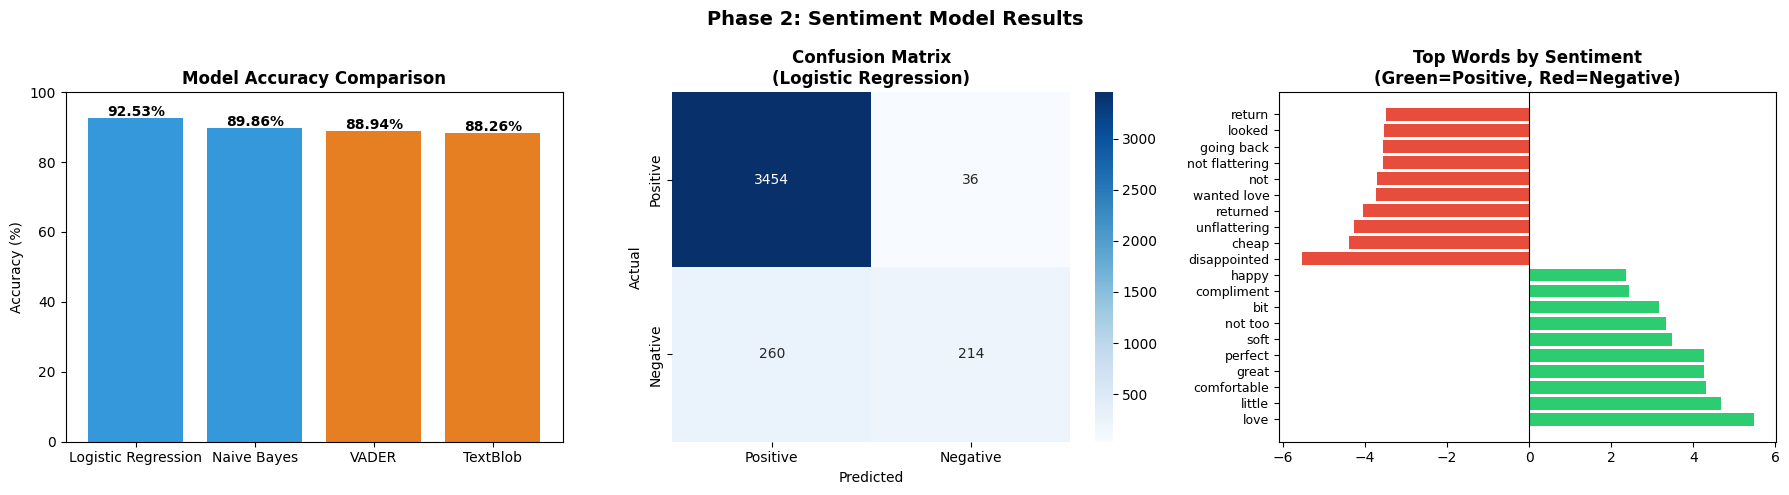

Chart saved: model_results.png


In [8]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

results = pd.DataFrame({
    'Model': ['TextBlob','VADER',
              'Logistic Regression','Naive Bayes'],
    'Accuracy': [
        round(textblob_acc*100, 2),
        round(vader_acc*100, 2),
        round(lr_acc*100, 2),
        round(nb_acc*100, 2)
    ],
    'Type': ['Rule-Based','Rule-Based','ML Model','ML Model']
})
results = results.sort_values('Accuracy', ascending=False)
print(results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Phase 2: Sentiment Model Results', fontsize=14, fontweight='bold')

# Plot 1: Model Comparison Bar Chart
colors = ['#3498db' if t == 'ML Model' else '#e67e22'
          for t in results['Type']]
bars = axes[0].bar(results['Model'], results['Accuracy'], color=colors)
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(0, 100)
for bar, acc in zip(bars, results['Accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.5,
                 f'{acc}%', ha='center', fontweight='bold')

# Plot 2: Confusion Matrix (Logistic Regression)
cm = confusion_matrix(y_test, lr_pred,
                       labels=['Positive','Negative'])
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1],
            cmap='Blues',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
axes[1].set_title('Confusion Matrix\n(Logistic Regression)', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Plot 3: Top 20 Important Words
feature_names = tfidf.get_feature_names_out()
lr_coefs      = lr_model.coef_[0]
top_positive  = pd.Series(lr_coefs, index=feature_names).nlargest(10)
top_negative  = pd.Series(lr_coefs, index=feature_names).nsmallest(10)
top_words     = pd.concat([top_positive, top_negative])

colors_words = ['#2ecc71' if c > 0 else '#e74c3c'
                for c in top_words.values]
axes[2].barh(range(len(top_words)), top_words.values, color=colors_words)
axes[2].set_yticks(range(len(top_words)))
axes[2].set_yticklabels(top_words.index, fontsize=9)
axes[2].set_title('Top Words by Sentiment\n(Green=Positive, Red=Negative)',
                  fontweight='bold')
axes[2].axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('model_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved: model_results.png")

In [10]:
# Save the best model
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Model saved: sentiment_model.pkl")
print("Vectorizer saved: tfidf_vectorizer.pkl")

# ── Predict on NEW reviews ──
def predict_sentiment(review_text):
    """Predict sentiment of any new review"""
    # Preprocess
    cleaned = preprocess_text(review_text)
    # Vectorize
    vectorized = tfidf.transform([cleaned])
    # Predict
    prediction = lr_model.predict(vectorized)[0]
    confidence = lr_model.predict_proba(vectorized).max() * 100
    # VADER score too
    vader_score = analyzer.polarity_scores(review_text)['compound']
    
    return {
        'review': review_text[:80] + '...',
        'prediction': prediction,
        'confidence': f"{confidence:.1f}%",
        'vader_score': round(vader_score, 3)
    }

# Test with sample reviews
print("\nTesting with Sample Reviews:")
print("="*60)
test_reviews = [
    "I absolutely love this dress! Perfect fit and beautiful color!",
    "Terrible quality, fell apart after one wash. Very disappointed.",
    "It's okay, nothing special. Decent for the price I guess.",
    "Runs very small, ordered 2 sizes up. Beautiful fabric though!"
]
for review in test_reviews:
    result = predict_sentiment(review)
    emoji = "" if result['prediction']=='Positive' else ""
    print(f"\n{emoji} Prediction: {result['prediction']} "
          f"(Confidence: {result['confidence']})")
    print(f"   Review: {result['review']}")

Model saved: sentiment_model.pkl
Vectorizer saved: tfidf_vectorizer.pkl

Testing with Sample Reviews:

 Prediction: Positive (Confidence: 99.6%)
   Review: I absolutely love this dress! Perfect fit and beautiful color!...

 Prediction: Negative (Confidence: 96.6%)
   Review: Terrible quality, fell apart after one wash. Very disappointed....

 Prediction: Positive (Confidence: 65.4%)
   Review: It's okay, nothing special. Decent for the price I guess....

 Prediction: Positive (Confidence: 81.5%)
   Review: Runs very small, ordered 2 sizes up. Beautiful fabric though!...


In [12]:
# Add ML predictions to full dataset
df['processed_text']  = df['cleaned_review'].apply(preprocess_text)
df['ml_prediction']   = lr_model.predict(
                            tfidf.transform(df['processed_text']))
df['vader_score']     = df['review_text'].apply(
                            lambda x: analyzer.polarity_scores(
                                str(x))['compound'])
df['textblob_score']  = df['review_text'].apply(
                            lambda x: TextBlob(str(x)).sentiment.polarity)

# Save enriched dataset for Power BI
df.to_csv('reviews_with_predictions.csv', index=False)
print("Saved: reviews_with_predictions.csv  →  use this in Power BI!")

# Save to database
conn = sqlite3.connect('sentiment_analysis.db')
df.to_sql('reviews_ml', conn, if_exists='replace', index=False)
conn.close()
print("Database updated with ML predictions!")

print("\nPHASE 2 COMPLETE!")
print("Files Created:")
print("   1. sentiment_model.pkl           → Trained ML model")
print("   2. tfidf_vectorizer.pkl          → Text vectorizer")
print("   3. model_results.png             → Model comparison charts")
print("   4. reviews_with_predictions.csv  → For Power BI dashboard")


Saved: reviews_with_predictions.csv  →  use this in Power BI!
Database updated with ML predictions!

PHASE 2 COMPLETE!
Files Created:
   1. sentiment_model.pkl           → Trained ML model
   2. tfidf_vectorizer.pkl          → Text vectorizer
   3. model_results.png             → Model comparison charts
   4. reviews_with_predictions.csv  → For Power BI dashboard
